In [1]:
import ssid
import quakeio
from ssid import modal, spec
from ssid.utilities import Config, extract_channels, print_modes, mode_statistics

### Data inputs

In [2]:
directory = "../CESMD/CE58658/"
# pattern = "sanlorenzo_28june2021.zip"
pattern = "*[sb][ae][nr][lk]*"

from pathlib import Path
files = list(Path(directory).glob(pattern))

In [3]:
data_conf = Config()

# HAYWARD TRANSVERSE (CASE 1)
title = "Hayward Bridge Transverse Mode (In: Ch25, Out: Ch23)"
data_conf.inputs  = [25,2,7,18]
data_conf.outputs = [23,13,15,20]
# # HAYWARD LONGITUDINAL (CASE 2)
# title = "Hayward Bridge Longitudinal Mode (In: Ch3, Out: Ch12)"
# data_conf.inputs  = [3,6,17]
# data_conf.outputs = [12,14,19]

In [4]:
# Set Parameters
conf = Config()
conf.m  = 500
conf.horizon = 190
conf.nc = 190
conf.order  = 12
conf.a  = 0  
conf.b  = 0  
conf.l  = 10 
conf.g  = 3
conf.period_band = (0.2,1.6)
conf.damping = 0.06
conf.pseudo = True
conf.outlook = 190

../CESMD/CE58658/berkeley_04jan2018_72948801_ce58658p.zip
peak acceleration (cm/s/s): 39.371


100%|█████████▉| 1385/1386 [00:00<00:00, 1497.88it/s]


Spectral quantities:
       T(s)        ζ        EMACO        MPC     EMACO*MPC
      1.094      0.002945   1.0        0.9979     0.9979   
      0.8148     0.005393   1.0        0.9806     0.9806   
      0.6051     0.04245    1.0        0.4734     0.4734   
      0.3792     0.03203    1.0        0.756      0.756    
      0.2919     0.0996     1.0        0.158      0.158    
      0.2283     0.01832    1.0        0.9941     0.9941   
Mean Period(s): 0.5688467945890036
Standard Dev(s): 0.3071316117209296
../CESMD/CE58658/sanlorenzo_28june2021.zip
peak acceleration (cm/s/s): 126.113


100%|█████████▉| 660/661 [00:00<00:00, 1915.07it/s]


Spectral quantities:
       T(s)        ζ        EMACO        MPC     EMACO*MPC
      0.3524     0.9943     0.0        0.4386     0.0      
      0.2526     0.2316     1.0        0.9801     0.9801   
      0.2419     0.5222     0.0        0.2521     0.0      
      0.2026     0.9782     0.0        0.6725     0.0      
Mean Period(s): 0.2623737022342967
Standard Dev(s): 0.05521135487068783


/mnt/c/Users/cmp/Documents/GitHub/SystemIdentification/src/ssid/validation.py:84: RuntimeWarning: divide by zero encountered in scalar divide
  nu[i]    = (s22[i]-s11[i])/(2*s12[i])
/mnt/c/Users/cmp/Documents/GitHub/SystemIdentification/src/ssid/validation.py:85: RuntimeWarning: invalid value encountered in scalar multiply
  lam[0,i] = (s11[i]+s22[i])/2 + s12[i]*np.sqrt(nu[i]**2+1)
/mnt/c/Users/cmp/Documents/GitHub/SystemIdentification/src/ssid/validation.py:86: RuntimeWarning: invalid value encountered in scalar multiply
  lam[1,i] = (s11[i]+s22[i])/2 - s12[i]*np.sqrt(nu[i]**2+1)


Text(0.5, 0.98, 'Hayward Bridge Transverse Mode (In: Ch25, Out: Ch23)')

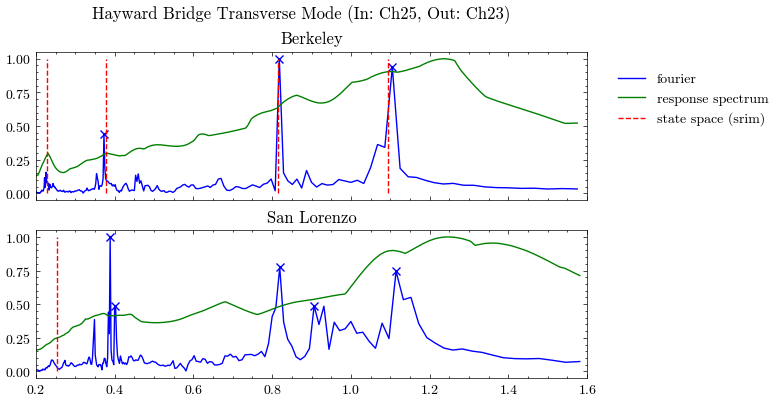

In [5]:
from scipy.signal import find_peaks

event_names = ["Berkeley", "San Lorenzo"]
event_modes = []
from matplotlib import pyplot as plt
file_axes = {}

fig, axs = plt.subplots(len(files), figsize=(6,2*len(files)), sharex=True, constrained_layout=True)
axi = iter(axs)

method = "srim"

for i, file in enumerate(files):
    ax = next(axi)
    # fig, ax = plt.subplots(figsize=(10,5))
    print(file)
    try:
        event = quakeio.read(file, exclusions=["*filter*", "*date*"])
        print("peak acceleration (cm/s/s):", event["peak_accel"])
        inputs, dt = extract_channels(event, data_conf.inputs)
        outpts, dt = extract_channels(event, data_conf.outputs)
        conf.decimation = 8 # decimation factor for state space method
        realization = ssid.system(method=method, inputs=inputs, outputs=outpts, threads=18, chunk=200, **conf)
    except Exception as e:
        # raise e
        print(e)
        continue
    ss_modes = modal.system_modes(realization,dt,**conf)
    event_modes.append(list(ss_modes.values()))
    print_modes(ss_modes)
    conf.decimation = 1 # decimation factor for transfer function method
    f_periods, f_amplitudes = spec.fourier_transfer(inputs=inputs[0], outputs=outpts[0], step=dt, **conf)
    f_amplitudes = f_amplitudes/max(f_amplitudes)
    peaks, _ = find_peaks(f_amplitudes, height=0.4, width=0.2, rel_height=0.1)
    ax.plot(f_periods, f_amplitudes, label=["fourier" if i==0 else None][0], color="blue") #, alpha = (1/(len(files)+2))*(i+1))
    ax.plot(f_periods[peaks], f_amplitudes[peaks], "bx")
    r_periods, r_amplitudes = spec.response_transfer(inputs=inputs[0], outputs=outpts[0], step=dt, periods=f_periods, threads=8, **conf)
    r_amplitudes = r_amplitudes/max(r_amplitudes)
    ax.plot(r_periods, r_amplitudes, label=["response spectrum" if i==0 else None][0], color="green") #, alpha = (1/(len(files)+2))*(i+1))
    ax.vlines([1/value["freq"] for value in ss_modes.values() if value["energy_condensed_emaco"]>0.5 and value["mpc"]>0.5], 0, 1, color='r', linestyles='dashed', label=[f"state space ({method})" if i==0 else None][0])
    ax.set_xlim(conf.period_band)
    ax.set_title(event_names[i])
fig.legend(bbox_to_anchor=(1.3,0.85))
event_frequencies = mode_statistics(event_modes, "freq")  
fig.suptitle(title)